In [6]:
import cv2
import mediapipe as mp
import os

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import argparse
import itertools
import copy

import pickle

import tensorflow as tf
from tensorflow import keras
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

##### Labels for prediction

In [7]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
numLabels = len(labels)

## Capturing landmarks for building dataset
First two cells are for initialization of CSVs

In [3]:
# num_coords = len(results.right_hand_landmarks.landmark)
# landmarks = ['label']
# for val in range(1, num_coords+1):
#     landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]
    
# print(landmarks)

In [4]:
# with open('hol_landmarks_right.csv', mode='w', newline='') as f:
#                             csv_writer = csv.writer(f, delimiter=',', quotechar='"')
#                             csv_writer.writerow(landmarks)
# with open('hol_landmarks_left.csv', mode='w', newline='') as f:
#                             csv_writer = csv.writer(f, delimiter=',', quotechar='"')
#                             csv_writer.writerow(landmarks)

In [5]:
def write_to_csv_right(label,landmarks):
    path = 'hol_landmarks_right.csv'
    with open(path, 'a', newline="") as f:
        r_row = csv.writer(f)
        r_row.writerow([label, *landmarks])
    return

def write_to_csv_left(label,landmarks):
    path = 'hol_landmarks_left.csv'
    with open(path, 'a', newline="") as f:
        l_row = csv.writer(f)
        l_row.writerow([label, *landmarks])
    return

#### Important Functions

In [6]:
def getLabel(key):
    label = chr(key)
    return label

In [12]:
def preprocess_landmark(landmarks):
    temp_landmarks = copy.deepcopy(landmarks)
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmarks):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]
        temp_landmarks[index][0] = temp_landmarks[index][0] - base_x
        temp_landmarks[index][1] = temp_landmarks[index][1] - base_y

    temp_landmarks = list(itertools.chain.from_iterable(temp_landmarks))
    max_value = max(list(map(abs, temp_landmarks)))

    def normalize_(n):
        return n / max_value
    temp_landmarks = list(map(normalize_, temp_landmarks))
    
    return temp_landmarks

In [11]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

## Read preprocessed landmarks into a dataset
Pressing a letter will write whatever the current landmarks drawn are to the dataset with the associated label index

In [86]:
mphands = mp.solutions.hands
hands = mphands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5,
    )
mp_drawing = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

_, frame = cap.read()
h, w, c = frame.shape

index = 0

while True:
    key=cv2.waitKey(2)
    if key != -1:
        label=getLabel(key).upper()
        #print(label)
    _, frame = cap.read()
    img_debug=copy.deepcopy(frame)
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    framergb.flags.writeable = True
    result = hands.process(framergb)
    framergb.flags.writeable = False
    hand_landmarks = result.multi_hand_landmarks
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            #print(handLMs)
            landmarks = calc_landmark_list(framergb, handLMs)
            #print(landmarks)
            pre_processed_landmarks = preprocess_landmark(landmarks)
            #print(pre_processed_landmarks)
            try:
                temp_key=getLabel(cv2.waitKey(2)).upper()
                if temp_key == label and temp_key != '0':
                    write_to_csv_right(ord(label)-65,pre_processed_landmarks)
                    index += 1
                    if index == 300:
                        print(f'Data Max for {label}')
                        index = 0
            except:
                pass
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            mp_drawing.draw_landmarks(frame, handLMs, mphands.HAND_CONNECTIONS)
    cv2.imshow("Get landmarks for dataset", frame)
    if cv2.waitKey(10) & 0xFF == ord('0'):
            break
cap.release()
cv2.destroyAllWindows()

# Training Model using SciKit 
### (EXPERIMENTATION BEFORE TF MODELLING)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [20]:
df = pd.read_csv('hol_landmarks.csv')

In [12]:
X = df.drop('label', axis=1)
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [16]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier())
}

In [17]:
list(pipelines.values())[0]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train.values, y_train)
    fit_models[algo] = model

In [19]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

In [ ]:
fit_models['rf'].predict(X_test)

In [ ]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

In [23]:
with open('sign_language_gb.pkl', 'wb') as f:
    pickle.dump(fit_models['gb'], f)

# Testing Detections

### Detection for pickle model

In [22]:
with open('sign_language_gb.pkl', 'rb') as f:
    model = pickle.load(f)

In [87]:
cap = cv2.VideoCapture(0)
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = holistic.process(image)
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
        
        try:
            #Extract right hand landmarks
            sign_right = results.right_hand_landmarks.landmark
            sign_right_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in sign_right]).flatten())
            testX = pd.DataFrame([sign_right_row])
            sign_language_class = model.predict(testX)[0]
            sign_language_prob = model.predict_proba(testX)[0]
            image = cv2.putText(image, "{}".format(sign_language_class), (90,400), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 5)
            #print(sign_language_class, sign_language_prob)
        except:
            pass
                        
        cv2.imshow('Hand Model Frames', image)

        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

cap.release()
cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

# TensorFlow NN Model Training

#### Paths

In [52]:
landmarks_dataset = 'hol_landmarks_right.csv'
#landmarks_dataset = 'hol_landmarks_left.csv'
model_path = 'sign_lang_detect_right.hdf5'
tflite_right_save_path = 'sign_lang_detect_right.tflite'
#tflite_left_save_path = 'sign_lang_detect_left.tflite'

#### Get data from CSV

In [53]:
tdf = pd.read_csv(landmarks_dataset)
X = np.loadtxt(landmarks_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y = np.loadtxt(landmarks_dataset, delimiter=',', dtype='int32', usecols=(0))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Define Model

In [55]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(numLabels, activation='softmax')
])

tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [56]:
tf_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint_path = model_path
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

#### Train Model

In [57]:
history = tf_model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/1000
45/46 [============================>.] - ETA: 0s - loss: 3.2579 - accuracy: 0.0538
Epoch 1: val_accuracy improved from -inf to 0.14936, saving model to sign_lang_detect_right.hdf5
46/46 [==============================] - 0s 4ms/step - loss: 3.2561 - accuracy: 0.0546 - val_loss: 3.1588 - val_accuracy: 0.1494
Epoch 2/1000
 1/46 [..............................] - ETA: 0s - loss: 3.1557 - accuracy: 0.0859
Epoch 2: val_accuracy did not improve from 0.14936
46/46 [==============================] - 0s 2ms/step - loss: 3.1177 - accuracy: 0.0905 - val_loss: 2.9901 - val_accuracy: 0.1028
Epoch 3/1000
 1/46 [..............................] - ETA: 0s - loss: 3.0681 - accuracy: 0.0859
Epoch 3: val_accuracy improved from 0.14936 to 0.18670, saving model to sign_lang_detect_right.hdf5
46/46 [==============================] - 0s 2ms/step - loss: 2.9848 - accuracy: 0.1057 - val_loss: 2.8118 - val_accuracy: 0.1867
Epoch 4/1000
 1/46 [..............................] - ETA: 0s - loss: 2.9583 

Epoch 27/1000
 1/46 [..............................] - ETA: 0s - loss: 1.4718 - accuracy: 0.5078
Epoch 27: val_accuracy improved from 0.83785 to 0.84399, saving model to sign_lang_detect_right.hdf5
46/46 [==============================] - 0s 2ms/step - loss: 1.5563 - accuracy: 0.4631 - val_loss: 0.9631 - val_accuracy: 0.8440
Epoch 28/1000
 1/46 [..............................] - ETA: 0s - loss: 1.6654 - accuracy: 0.4609
Epoch 28: val_accuracy did not improve from 0.84399
46/46 [==============================] - 0s 2ms/step - loss: 1.5284 - accuracy: 0.4791 - val_loss: 0.9435 - val_accuracy: 0.8384
Epoch 29/1000
 1/46 [..............................] - ETA: 0s - loss: 1.4782 - accuracy: 0.5000
Epoch 29: val_accuracy did not improve from 0.84399
46/46 [==============================] - 0s 2ms/step - loss: 1.5272 - accuracy: 0.4810 - val_loss: 0.9165 - val_accuracy: 0.8353
Epoch 30/1000
 1/46 [..............................] - ETA: 0s - loss: 1.4987 - accuracy: 0.5000
Epoch 30: val_accura

Epoch 55/1000
 1/46 [..............................] - ETA: 0s - loss: 1.2455 - accuracy: 0.6016
Epoch 55: val_accuracy did not improve from 0.90281
46/46 [==============================] - 0s 2ms/step - loss: 1.2482 - accuracy: 0.5707 - val_loss: 0.6166 - val_accuracy: 0.8977
Epoch 56/1000
46/46 [==============================] - ETA: 0s - loss: 1.2563 - accuracy: 0.5608
Epoch 56: val_accuracy did not improve from 0.90281
46/46 [==============================] - 0s 2ms/step - loss: 1.2563 - accuracy: 0.5608 - val_loss: 0.6065 - val_accuracy: 0.8752
Epoch 57/1000
40/46 [=========================>....] - ETA: 0s - loss: 1.2465 - accuracy: 0.5721
Epoch 57: val_accuracy did not improve from 0.90281
46/46 [==============================] - 0s 2ms/step - loss: 1.2552 - accuracy: 0.5691 - val_loss: 0.6008 - val_accuracy: 0.8726
Epoch 58/1000
46/46 [==============================] - ETA: 0s - loss: 1.2302 - accuracy: 0.5814
Epoch 58: val_accuracy did not improve from 0.90281
46/46 [==========

In [58]:
val_loss, val_acc = tf_model.evaluate(X_test, y_test, batch_size=128)
model = tf.keras.models.load_model(model_path)
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

16/16 [==============================] - 0s 733us/step - loss: 0.4658 - accuracy: 0.8936
[2.1035418e-02 3.2589700e-02 1.6009230e-02 4.0949851e-01 2.0647235e-02
 2.6306069e-02 6.7693187e-04 2.4861665e-04 3.0298296e-03 1.7139855e-04
 1.0571290e-01 5.5309958e-03 3.5722170e-03 2.7975751e-02 4.7152431e-04
 8.8016759e-06 5.5886092e-05 2.0290645e-02 1.9371571e-02 1.5379746e-03
 3.1089666e-03 3.1808745e-02 3.1119122e-03 3.7416954e-02 2.6557096e-03
 2.0715652e-01]
3


## Evaluate Model

### Graph

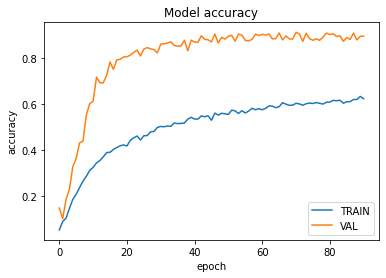

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

### Confusion Matrix

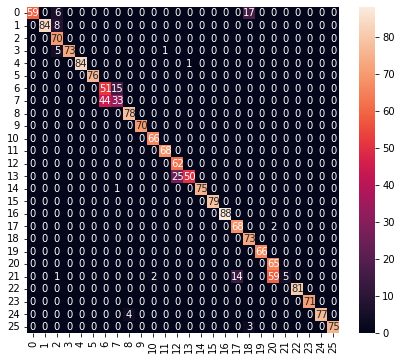

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        82
           1       1.00      0.91      0.95        92
           2       0.78      1.00      0.88        70
           3       1.00      0.92      0.96        79
           4       1.00      0.99      0.99        85
           5       1.00      1.00      1.00        76
           6       0.54      0.77      0.63        66
           7       0.67      0.43      0.52        77
           8       0.95      1.00      0.97        78
           9       1.00      1.00      1.00        70
          10       0.97      1.00      0.99        66
          11       0.99      1.00      0.99        68
          12       0.71      1.00      0.83        62
          13       0.98      0.67      0.79        75
          14       1.00      0.99      0.99        76
          15       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        88
     

In [68]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = tf_model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [69]:
loss, accuracy = tf_model.evaluate(X_test, y_test)

62/62 [==============================] - 0s 557us/step - loss: 0.4658 - accuracy: 0.8936


# TFLite Model Conversion

In [70]:
model.save(model_path, include_optimizer=False)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
#tflite_quantized_model

open(tflite_right_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Shiv\AppData\Local\Temp\tmpmoghmbn7\assets


INFO:tensorflow:Assets written to: C:\Users\Shiv\AppData\Local\Temp\tmpmoghmbn7\assets


7392

## Detection for TensorFlowLite Model

In [3]:
class SignClassifier(object):
    def __init__(self,model_path='sign_lang_detect_right.tflite',num_threads=1,):
        self.interpreter = tf.lite.Interpreter(model_path=model_path,num_threads=num_threads)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def __call__(self,landmark_list,):
        input_details_tensor_index = self.input_details[0]['index']
        self.interpreter.set_tensor(input_details_tensor_index,np.array([landmark_list], dtype=np.float32))
        self.interpreter.invoke()

        output_details_tensor_index = self.output_details[0]['index']
        result = self.interpreter.get_tensor(output_details_tensor_index)
        result_index = np.argmax(np.squeeze(result))

        return result_index

In [ ]:
sign_classifier = SignClassifier()
mphands = mp.solutions.hands
hands = mphands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5,
    )
mp_drawing = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

_, frame = cap.read()
h, w, c = frame.shape
index = 0

while True:
    _, frame = cap.read()
    img_debug=copy.deepcopy(frame)
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    framergb.flags.writeable = True
    result = hands.process(framergb)
    framergb.flags.writeable = False
    hand_landmarks = result.multi_hand_landmarks
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            landmarks = calc_landmark_list(framergb, handLMs)
            pre_processed_landmarks = preprocess_landmark(landmarks)
            sign_language_class = sign_classifier(pre_processed_landmarks)
            sign_language_prob = tf_model.predict_proba(pre_processed_landmarks)
            frame = cv2.putText(frame, "{}".format(labels[sign_language_class]), (90,400), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 5)
            print(sign_language_class, sign_language_prob)
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            mp_drawing.draw_landmarks(frame, handLMs, mphands.HAND_CONNECTIONS)
    cv2.imshow("Test", frame)
    if cv2.waitKey(10) & 0xFF == ord('x'):
            break
cap.release()
cv2.destroyAllWindows()